In [16]:
import os
import pandas as pd
import xarray as xr
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from shapely.geometry.polygon import Polygon, LineString
import folium


In [2]:
path_rap = "/glade/p/cisl/aiml/conv_risk_intel/rap_ncei_nc/"
path_save = "/glade/p/cisl/aiml/jtti_tornado/rap_contours/"


In [3]:
date = '20070524'


In [18]:
df = pd.DataFrame()
for f in [f for f in os.listdir(os.path.join(path_rap, date)) if f.endswith('.nc')][:1]:
    ds = xr.open_dataset(os.path.join(path_rap, date, f))
    lons = ds.longitude.values - 360
    lats = ds.latitude.values
    hour = f[-11:-9]
    try:
        sbcape = ds.sel(press=1000).to_dataframe()['SBCAPE'].unstack('y').values
    except Exception as e:
        print('--', f, e)
        continue
    for intensity in [1e-12,1000,2000,3000,4000,5000][:1]:
        contours = measure.find_contours(sbcape, intensity)
        for i,contour in enumerate(contours[:44]):
            if contour.shape[0] < 3:
                continue
            else:
                contour = np.round(contour).astype(int)
                lons_contour = lons[contour[:, 1:2], contour[:, 0:1]]
                lats_contour = lats[contour[:, 1:2], contour[:, 0:1]]
                contour_ll = np.hstack((lons_contour, lats_contour))
#                 print(i, Polygon(contour))
                contour_dict = {"intensity": intensity, "date":date, "hour":hour, "geometry": LineString(contour_ll)}
                df = df.append(contour_dict, ignore_index=True)
gdf = gpd.GeoDataFrame(df, geometry="geometry")


In [5]:
contour.shape

(2896, 2)

In [6]:
contour[:10]

array([[160,   0],
       [160,   1],
       [160,   2],
       [161,   3],
       [161,   3],
       [162,   4],
       [163,   4],
       [164,   4],
       [164,   4],
       [164,   5]])

In [7]:
contour_ll[:10]

array([[-106.05712551,   19.28608541],
       [-106.06759744,   19.40690708],
       [-106.07808919,   19.5277524 ],
       [-105.96023732,   19.65847262],
       [-105.96023732,   19.65847262],
       [-105.84214393,   19.78912345],
       [-105.71362032,   19.79875751],
       [-105.58507742,   19.80827706],
       [-105.58507742,   19.80827706],
       [-105.59514432,   19.92923424]])

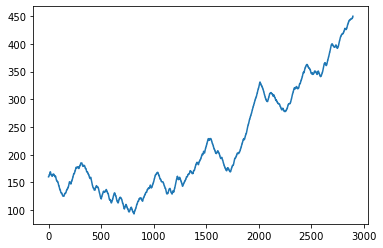

In [19]:
plt.plot(contour[:, 0])

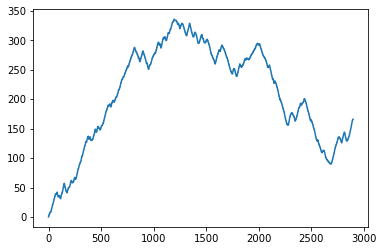

In [20]:
plt.plot(contour[:, 1])

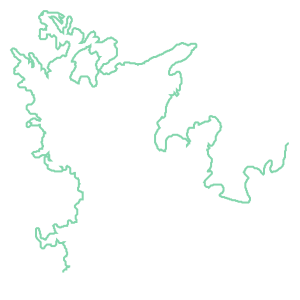

In [21]:
LineString(contour)

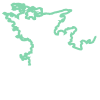

In [22]:
LineString(contour_ll)

In [23]:
m = folium.Map(location=[40, -100], zoom_start=4, tiles='CartoDB positron')
for _, r in gdf[43:44].iterrows():
    sim_geo = gpd.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['intensity']).add_to(geo_j)
    geo_j.add_to(m)
m


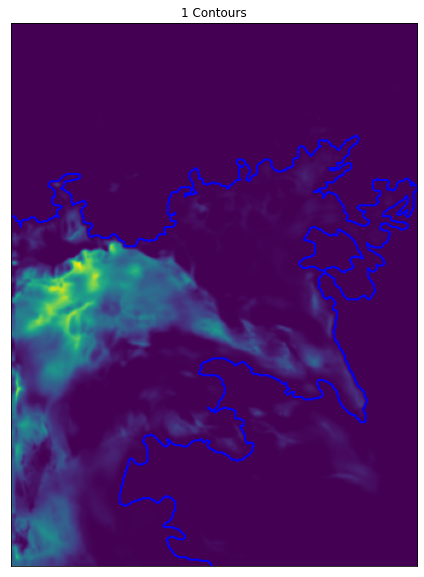

In [14]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
fig, ax = plt.subplots(figsize=(8,10))
ax.imshow(sbcape)
contour_count =0
for i,intensity in enumerate([1e-12,1000,2000,3000,4000,5000]):
    contours = measure.find_contours(sbcape, intensity)
    for contour in contours[43:44]:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color=colors[i])
        contour_count += 1
ax.set_title(f'{contour_count} Contours')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


In [15]:
print(contour[0])
print(contour[-1])

[160.   0.]
[450. 166.]


In [ ]:
# can draw line between endpoints
